# ✅ Сравним собственную реализацию дерева с scikit-learn

## ⭐ Импорты

In [1]:
from time import time

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as tree_sk
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from upninja.models.Trees.DecisionTreeClassifier import DecisionTreeClassifier as tree_my

/Users/romanseleznyov/anaconda3/lib/python3.13/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
SEED = 8

## ⭐ Подготовим данные

In [3]:
dataset = pd.read_csv('data/breast-cancer.csv')
dataset.drop('id', axis=1, inplace=True)
dataset['diagnosis'] = (dataset['diagnosis'] == 'M').astype(int)

cor_target = abs(dataset.corr()['diagnosis'])
relevant_features = cor_target[cor_target>0.25]
names = [index for index, value in relevant_features.items()]
names.remove('diagnosis')

X = dataset[names].values
y = dataset['diagnosis'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.2)

## ⭐ Собственная реализация

In [4]:

my_tree = tree_my(min_samples=10,
                  max_depth=5,
                  criterion='entropy'
                 )

start_time = time()
my_tree.fit(X_train, y_train)
end_time = time()
pred = my_tree.predict(X_test)
print('⌛Fit time: ', end_time - start_time, ' (seconds)')
print('🎯Accuracy: ', accuracy_score(y_test, pred))

⌛Fit time:  1.7061851024627686  (seconds)
🎯Accuracy:  0.9385964912280702


## ⭐ Scikit-learn

In [5]:
sk_tree = tree_sk(min_samples_leaf=10,
                  max_depth=5,
                  criterion='entropy'
                 )

start_time = time()
sk_tree.fit(X_train, y_train)
end_time = time()
pred = sk_tree.predict(X_test)
print('⌛Fit time: ', end_time - start_time, ' (seconds)')
print('🎯Accuracy: ', accuracy_score(y_test, pred))

⌛Fit time:  0.0024590492248535156  (seconds)
🎯Accuracy:  0.9473684210526315


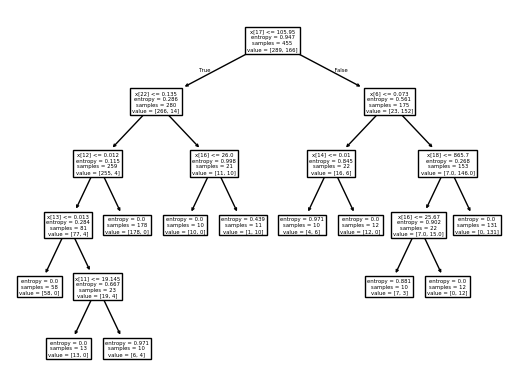

In [6]:
dt_plt = plot_tree(sk_tree)

# ✅ Протестируем собственную реализацию uplift дерева

## ⭐ Импорты

In [1]:
import numpy as np
import pandas as pd
from sklift.datasets import fetch_hillstrom
from sklearn.model_selection import train_test_split

from upninja.models.Trees.UpliftRandomForest import UpliftRandomForest

# econml
from econml.dml import CausalForestDML

# causalml
from causalml.inference.tree import UpliftRandomForestClassifier

/Users/romanseleznyov/Documents/UpliftNinja/uplift-env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/romanseleznyov/Documents/UpliftNinja/uplift-env/lib/python3.13/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Failed to import duecredit due to No module named 'duecredit'


In [2]:
SEED = 8

In [3]:
data = fetch_hillstrom(target_col='visit')
df = data.data
X, y, w = df, data.target, data.treatment

# Hillstrom: treatment — 'Mens E-Mail', 'Womens E-Mail' -> объединим в бинарный treatment
w = (w != 'No E-Mail').astype(int)  # 1 — получили email, 0 — нет

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.2, random_state=SEED
)

num_cols = X_train.select_dtypes(exclude='object').columns
X_train = X_train[num_cols]
X_test = X_test[num_cols]

In [4]:
%%time

uplift_rf = UpliftRandomForest(
    n_estimators=50,
    max_depth=4,
    min_samples=100,
    min_samples_treatment=5,
    forest_criterion=None,
    tree_criterion='dml',
    random_state=SEED,
    n_jobs=8,
    verbose=2
)
uplift_rf.fit(X_train, y_train, w_train)
pred_our_rf = uplift_rf.predict(X_test)

[UpliftRandomForest] Fitting 50 trees in parallel (n_jobs=8)...


/Users/romanseleznyov/Documents/UpliftNinja/uplift-env/lib/python3.13/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/romanseleznyov/Documents/UpliftNinja/uplift-env/lib/python3.13/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/romanseleznyov/Documents/UpliftNinja/uplift-env/lib/python3.13/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for re

[UpliftRandomForest] Fitting completed.
CPU times: user 436 ms, sys: 215 ms, total: 651 ms
Wall time: 1min 4s


In [5]:
%%time

causal_forest = CausalForestDML(
    criterion='het',
    n_estimators=48,
    max_depth=4,
    min_samples_split=100,
    subforest_size=4,
    random_state=SEED
)

causal_forest.fit(Y=y_train, T=w_train, X=X_train)
pred_econml_rf = causal_forest.effect(X_test)

CPU times: user 28 s, sys: 170 ms, total: 28.2 s
Wall time: 27.5 s


In [6]:
%%time

X_train_np, X_test_np, y_train_np, y_test_np, w_train_str, w_test_str = (
    X_train.values, X_test.values,
    y_train.values, y_test.values,
    np.where(w_train == 1, 'treatment', 'control'),
    np.where(w_test == 1, 'treatment', 'control')
)


causalml_forest = UpliftRandomForestClassifier(
    n_estimators=50,
    min_samples_leaf=100,
    max_depth=4,
    random_state=SEED,
    control_name='control'
)

causalml_forest.fit(
    X=X_train_np,
    treatment=w_train_str,
    y=y_train_np
)

causalml_forest.fit(X_train_np, w_train_str, y_train_np)
pred_causalml = causalml_forest.predict(X_test_np)

CPU times: user 4.91 s, sys: 757 ms, total: 5.67 s
Wall time: 2.99 s


In [7]:
from sklift.metrics import qini_auc_score, uplift_at_k

print("=== Сравнение по метрикам uplift ===")
print(f"Наш RF — Qini AUC: {qini_auc_score(y_test, pred_our_rf, w_test):.4f}")
print(f"econml — Qini AUC: {qini_auc_score(y_test, pred_econml_rf, w_test):.4f}")
print(f"causalnml — Qini AUC: {qini_auc_score(y_test_np, pred_causalml, w_test):.4f}")

print(f"\nUplift@30%:")
print(f"Наш RF: {uplift_at_k(y_test, pred_our_rf, w_test, strategy='by_group', k=0.3):.4f}")
print(f"econml: {uplift_at_k(y_test, pred_econml_rf, w_test, strategy='by_group', k=0.3):.4f}")
print(f"causalml: {uplift_at_k(y_test_np, pred_causalml, w_test, strategy='by_group', k=0.3):.4f}")

print(f"\nСредний uplift:")
print(f"Наш RF: {pred_our_rf.mean():.4f}")
print(f"econml: {pred_econml_rf.mean():.4f}")
print(f"causalml: {pred_causalml.mean():.4f}")

=== Сравнение по метрикам uplift ===
Наш RF — Qini AUC: 0.0170
econml — Qini AUC: 0.0229
causalnml — Qini AUC: -0.2065

Uplift@30%:
Наш RF: 0.0641
econml: 0.0670
causalml: nan

Средний uplift:
Наш RF: 0.0639
econml: 0.0627
causalml: 0.0625


/Users/romanseleznyov/Documents/UpliftNinja/uplift-env/lib/python3.13/site-packages/sklift/metrics/metrics.py:471: RuntimeWarning: Mean of empty slice.
  score_ctrl = y_true[order][treatment[order] == 0][:n_ctrl].mean()
/Users/romanseleznyov/Documents/UpliftNinja/uplift-env/lib/python3.13/site-packages/numpy/_core/_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


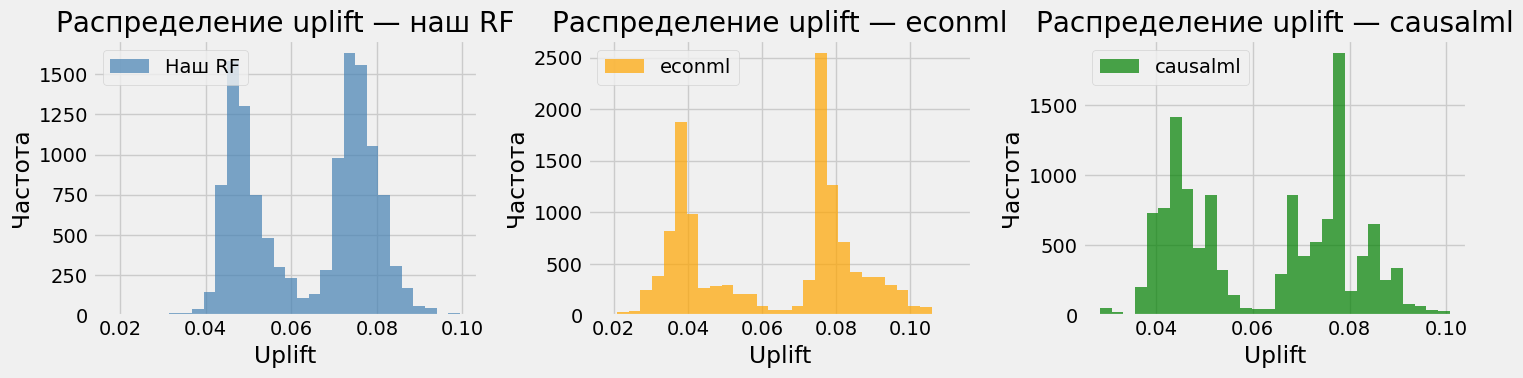

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(pred_our_rf, bins=30, alpha=0.7, color='steelblue', label='Наш RF')
plt.title('Распределение uplift — наш RF')
plt.xlabel('Uplift')
plt.ylabel('Частота')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(pred_econml_rf, bins=30, alpha=0.7, color='orange', label='econml')
plt.title('Распределение uplift — econml')
plt.xlabel('Uplift')
plt.ylabel('Частота')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(pred_causalml, bins=30, alpha=0.7, color='green', label='causalml')
plt.title('Распределение uplift — causalml')
plt.xlabel('Uplift')
plt.ylabel('Частота')
plt.legend()

plt.tight_layout()
plt.show()